# Preambule

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
from collections import OrderedDict
import pandas as pd
from scipy.stats import distributions as dst
import numpy as np

In [ ]:
def moving_average(a, n) :
    from numpy import cumsum
    ret = cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Parse metadata

In [3]:
filename = "Experiment1.lif"

In [4]:
md = bf.get_omexml_metadata("./data/"+filename)

xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
mdf = []
for i in range(Nimages):
    im = xml.image(index=i)
    tmp = OrderedDict([(attrib,getattr(im,attrib)) for attrib in ["Name","AcquisitionDate"]])
    for dim in "XYTCZ":
        tmp[dim] = getattr(im.Pixels, "Size"+dim)
    mdf += [tmp]

mdf = pd.DataFrame(mdf)

In [5]:
try:
    mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except:
    pass

In [6]:
mdf#.loc[:,["X","Y","T","inferedTimes"]]

,Name,AcquisitionDate,X,Y,T,C,Z
0,Image019,2019-07-01 14:02:42,1024,1024,1,1,1
1,Image022,2019-07-01 14:04:07,1024,1024,1,1,1
2,Series023,2019-07-01 14:04:44,512,512,1,1,1
3,Series024,2019-07-01 14:05:01,512,512,252,1,1
4,Series028,2019-07-01 14:10:44,64,64,13490,1,1
5,Series029,2019-07-01 14:14:10,512,512,415,1,1
6,Series030,2019-07-01 14:21:30,64,64,6478,1,1
7,Series032,2019-07-01 14:23:45,64,64,16644,1,1
8,Series033,2019-07-01 14:28:39,512,512,45,1,1
9,Series034,2019-07-01 14:29:20,512,512,756,1,1


# Light intensities distributions

In [7]:
Nsample = 1e6

In [8]:
rdr = bf.ImageReader("./data/"+filename, perform_init=True)

## Cumulative

Text(0.5, 0.98, 'cumulative distribution of values')

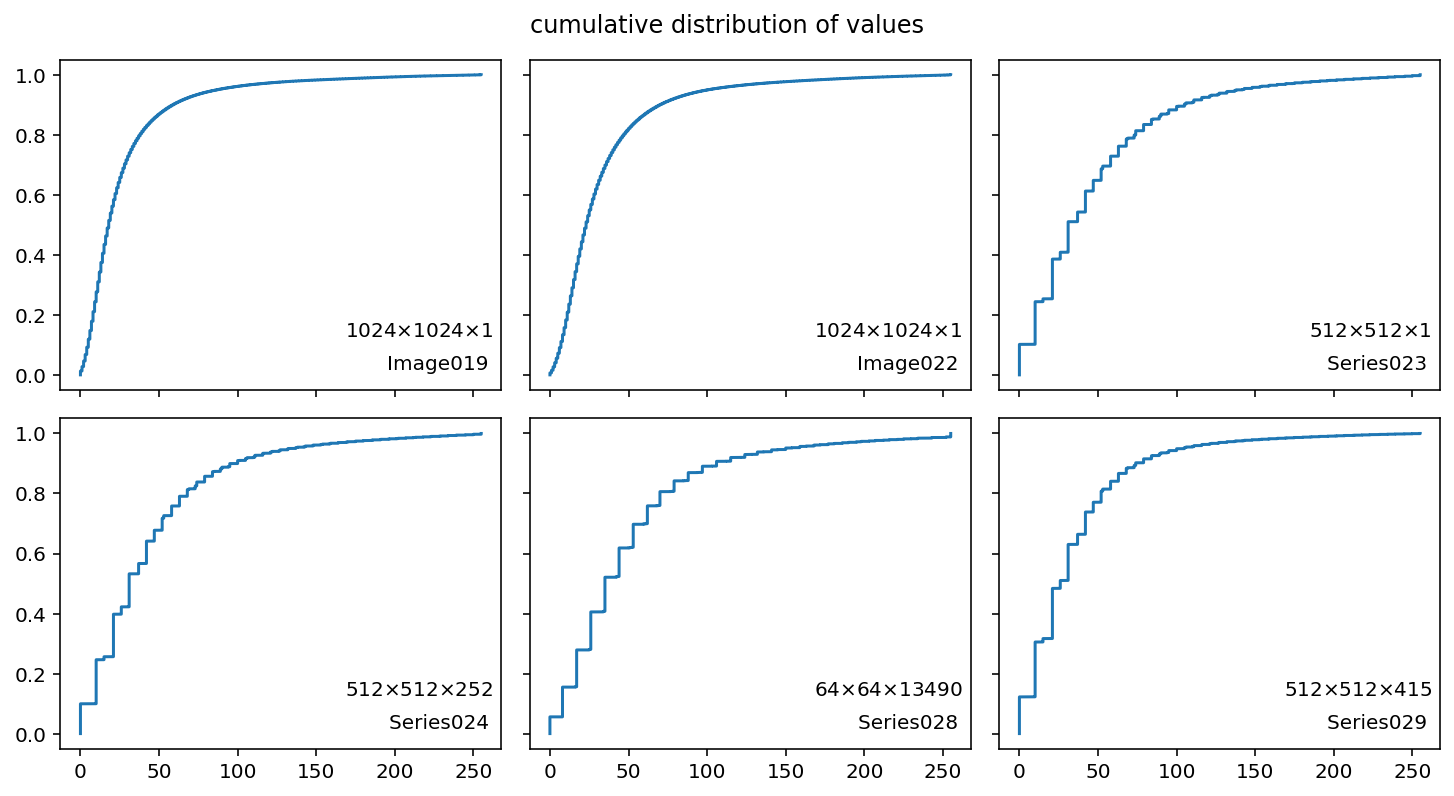

In [9]:
nr,nc = 2,3
fig,axs = plt.subplots(nr,nc,figsize=(nc*3.4,nr*2.8), sharex=True, sharey=True)
for ia,idx in enumerate(range(len(mdf))):
    try:
        ax = axs.flat[ia]
    except:
        break
    Name = mdf.loc[idx,"Name"]
    dimensions = mdf.loc[idx,list("XYZCT")]
    
    Ts = np.random.choice(range(dimensions["T"]),1+int(Nsample/(dimensions.X*dimensions.Y)))
    sampleSnapshots = np.array([
            rdr.read(series=idx,rescale=False,t=t) for t in Ts
        ])

    x = sampleSnapshots.flatten()
    ax.step(sorted(x), np.linspace(0,1,len(x)+1)[1:])
    ax.text(1,.15,r"$%i{\times}%i{\times}%i$  "%tuple(dimensions[list("XYT")]), 
            ha="right",va="bottom",transform=ax.transAxes)
    ax.text(1,.05,Name+"  ", 
            ha="right",va="bottom",transform=ax.transAxes)
#     break
for ax in axs.flat[ia:]:
    ax.remove()
fig.tight_layout(rect=(0,0,1,.95))
fig.suptitle("cumulative distribution of values")

## ordinary PDF

Text(0.5, 0.98, 'probability distribution of values')

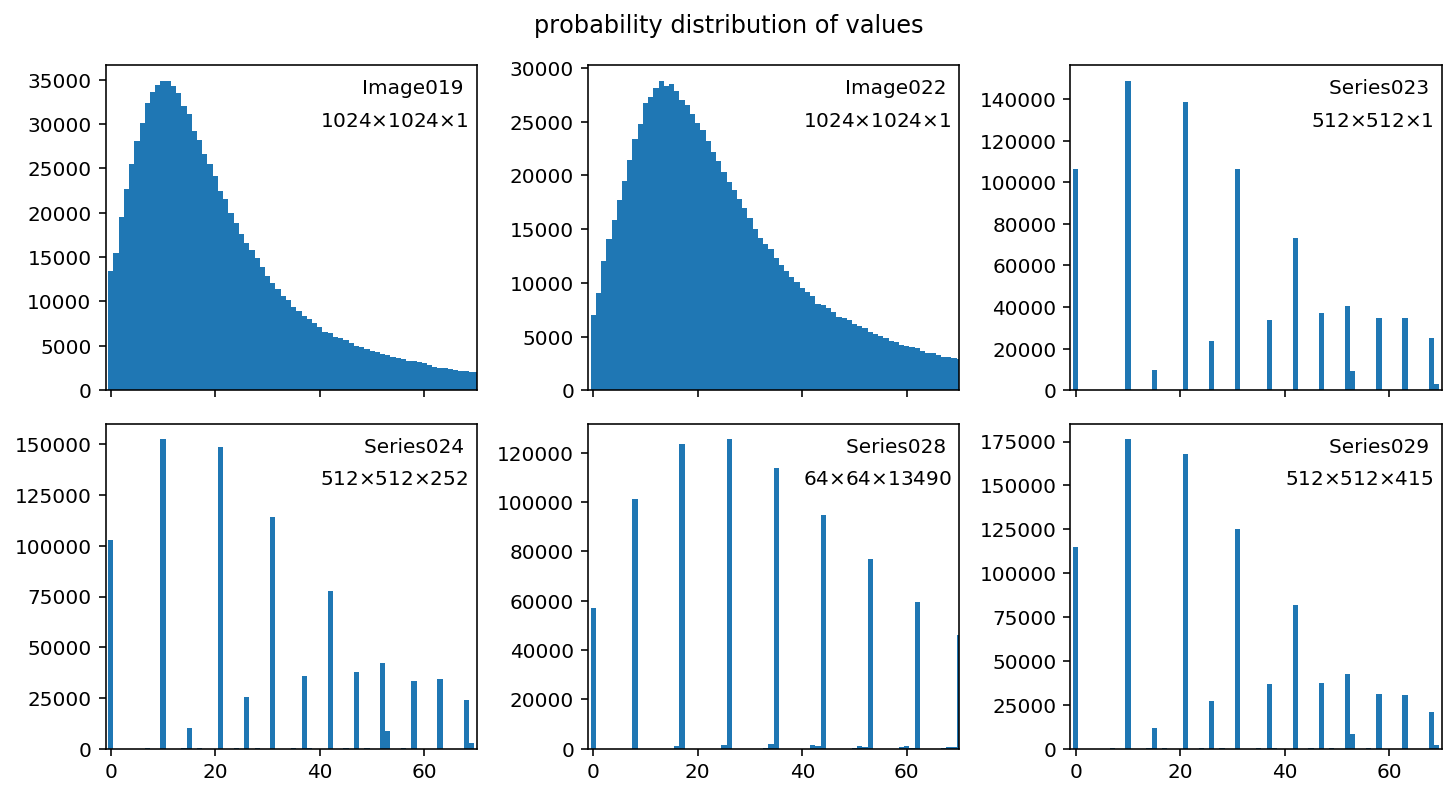

In [11]:
nr,nc = 2,3
fig,axs = plt.subplots(nr,nc,figsize=(nc*3.4,nr*2.8), sharex=True, sharey=False)
for ia,idx in enumerate(range(len(mdf))):
    try:
        ax = axs.flat[ia]
    except:
        break
    Name = mdf.loc[idx,"Name"]
    dimensions = mdf.loc[idx,list("XYZCT")]
    
    Ts = np.random.choice(range(dimensions["T"]),1+int(Nsample/(dimensions.X*dimensions.Y)))
    sampleSnapshots = np.array([
            rdr.read(series=idx,rescale=False,t=t) for t in Ts
        ])

    x = sampleSnapshots.flatten()
    ax.hist(x, np.arange(257)-.5)
    ax.text(1,.8,r"$%i{\times}%i{\times}%i$  "%tuple(dimensions[list("XYT")]), 
            ha="right",va="bottom",transform=ax.transAxes)
    ax.text(1,.9,Name+"  ", 
            ha="right",va="bottom",transform=ax.transAxes)
#     ax.set_yscale("log")
#     if ia>2: break
ax.set_xlim(-1,70)
for ax in axs.flat[ia:]:
    ax.remove()
fig.tight_layout(rect=(0,0,1,.95))
fig.suptitle("probability distribution of values")

# Check individual image

In [12]:
mdf.head()

,Name,AcquisitionDate,X,Y,T,C,Z
0,Image019,2019-07-01 14:02:42,1024,1024,1,1,1
1,Image022,2019-07-01 14:04:07,1024,1024,1,1,1
2,Series023,2019-07-01 14:04:44,512,512,1,1,1
3,Series024,2019-07-01 14:05:01,512,512,252,1,1
4,Series028,2019-07-01 14:10:44,64,64,13490,1,1


In [13]:
idx = 1
Name = mdf.loc[idx,"Name"]
dimensions = mdf.loc[idx,list("XYZCT")]
image = np.array([
            rdr.read(series=idx, rescale=False,t=t) for t in range(dimensions["T"])
        ])

In [14]:
image.shape

(1, 1024, 1024)

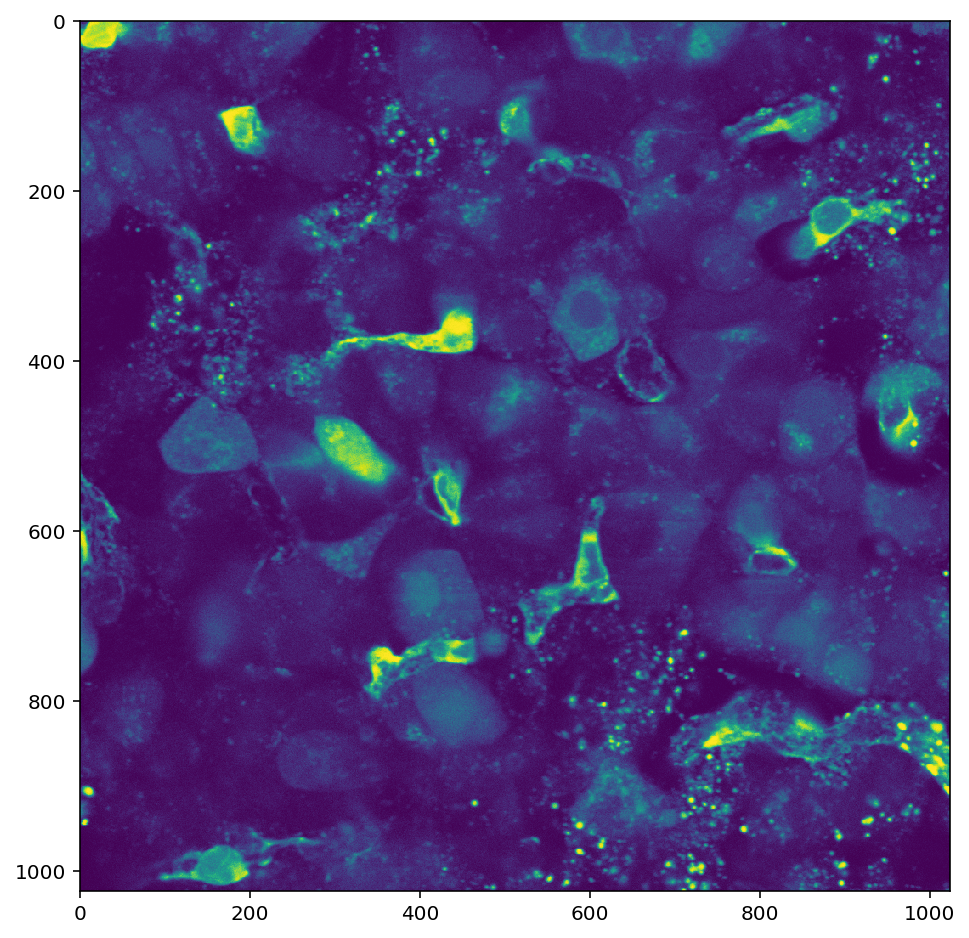

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(image[0])

# Kill javabridge

In [ ]:
javabridge.kill_vm()